# Base Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/train.csv")
df.head()

,Line Item ID,Date,App/URL ID,ISP or Carrier ID,Device Type,Exchange ID,Operating System,Browser,Creative Size,Advertiser Currency,Impressions,IO_ID,CPM
0,2,17-08-2020,1.5164E+11,1000,Desktop,1,Macintosh,Chrome,728x90,CAD,2,1,0.0105
1,2,17-08-2020,1362605575,1000,Desktop,1,Windows 10,Chrome,300x600,CAD,2,1,0.0125
2,2,17-08-2020,20303819748,207,Desktop,1,Windows 7,Chrome,160x600,CAD,2,1,0.0200
3,2,17-08-2020,20303819748,666,Desktop,1,Windows 10,Chrome,160x600,CAD,2,1,0.0350
4,2,17-08-2020,20303819748,1000,Desktop,1,Windows 10,Chrome,160x600,CAD,4,1,0.0220


## Model Training

In [3]:
df.columns = ['line_item_id', 'date', 'app_url_id', 'isp_or_carrier_id',
              'device_type', 'exchange_id', 'operating_system', 'browser',
              'creative_size', 'advertiser_currency', 'impressions', 'io_id', 'cpm']

In [4]:
# Change dtype of date
df['date'] = pd.to_datetime(df['date'], format = '%d-%m-%Y')
# get day of week
import datetime as dt
df['day_of_week'] = df['date'].dt.day_name()

In [5]:
# drop app/urls which are unknown, since its a very small fraction of the total data
unknown_app_ids = df[df['app_url_id'] == 'Unknown'].index
df.drop(unknown_app_ids, axis = 0, inplace = True)

In [6]:
# convert dtype of app_url_id
df['app_url_id'] = pd.to_numeric(df['app_url_id'])

In [7]:
df.head()

,line_item_id,date,app_url_id,isp_or_carrier_id,device_type,exchange_id,operating_system,browser,creative_size,advertiser_currency,impressions,io_id,cpm,day_of_week
0,2,2020-08-17,1.516400e+11,1000,Desktop,1,Macintosh,Chrome,728x90,CAD,2,1,0.0105,Monday
1,2,2020-08-17,1.362606e+09,1000,Desktop,1,Windows 10,Chrome,300x600,CAD,2,1,0.0125,Monday
2,2,2020-08-17,2.030382e+10,207,Desktop,1,Windows 7,Chrome,160x600,CAD,2,1,0.0200,Monday
3,2,2020-08-17,2.030382e+10,666,Desktop,1,Windows 10,Chrome,160x600,CAD,2,1,0.0350,Monday
4,2,2020-08-17,2.030382e+10,1000,Desktop,1,Windows 10,Chrome,160x600,CAD,4,1,0.0220,Monday


### Feature Scaling is not required because splitting of the nodes takes place on a single feature, so scale doesnt matter

### Encoder Techniques

    - Try l1,l2 regularization
    - try catboost in lightgbm
    - track R2, adjusted R2, RMSE.
    - Once encoding is fixed, Try NN.

#### Target Encoding
    Target Encoding is a bad choice here because it leaks the target
    variable's information into the training data. I am not going to use this

In [ ]:
#def target_encoder(df_temp, target, categorical, encoder):
# Target Encoding
# Make a copy of original dataset
df_temp = df.copy()
df_temp.drop(['line_item_id', 'io_id'], axis = 1, inplace = True)

categorical = ['app_url_id', 'device_type', 'operating_system', 
               'browser','creative_size', 'advertiser_currency','day_of_week']


enc = ce.TargetEncoder(cols = categorical)

# fit and transform
encoded_cols = enc.fit_transform(df_temp[categorical], df_temp['cpm'])

# merge encoded columns with dataset
df_temp[list(encoded_cols)] = encoded_cols

df_temp.head()

#### CatBoost Encoder
    - Supported for continuous targets
    - training data must be randomly permutated

In [8]:
#def catboost(df_temp, categorical, target, encoder):
from category_encoders import CatBoostEncoder
import category_encoders as ce

# Make a copy of original dataset
df_temp = df.copy()

# Random permutation 
#set a random seed for replication
seed = 2019
np.random.seed(seed)

perm = np.random.permutation(len(df_temp)) 
df_temp = df_temp.iloc[perm].reset_index(drop = True)

# CatBoostEncoder
categorical = ['app_url_id', 'operating_system',
               'browser','creative_size', 'advertiser_currency', 
               'device_type', 'day_of_week']
enc = CatBoostEncoder(cols = categorical, )

# fit and transform
cat_boost_encoded_cols = enc.fit_transform(df_temp[categorical], df_temp['cpm'])

# Merge encoded columns with original 
df_temp[list(cat_boost_encoded_cols)] = cat_boost_encoded_cols

#df_temp['cpm'] = target

df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1391924 entries, 0 to 1391923
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   line_item_id         1391924 non-null  int64         
 1   date                 1391924 non-null  datetime64[ns]
 2   app_url_id           1391924 non-null  float64       
 3   isp_or_carrier_id    1391924 non-null  int64         
 4   device_type          1391924 non-null  float64       
 5   exchange_id          1391924 non-null  int64         
 6   operating_system     1391924 non-null  float64       
 7   browser              1391924 non-null  float64       
 8   creative_size        1391924 non-null  float64       
 9   advertiser_currency  1391924 non-null  float64       
 10  impressions          1391924 non-null  int64         
 11  io_id                1391924 non-null  int64         
 12  cpm                  1391924 non-null  float64       
 1

#### JamesStein Encoder

In [ ]:
from category_encoders import JamesSteinEncoder
# Make a copy of original dataset
#df_temp = df.copy()
#df_temp.drop(['line_item_id', 'io_id'], axis = 1, inplace = True)

# Random permutation 
#perm = np.random.permutation(len(df_temp)) 
#X = X.iloc[perm].reset_index(drop=True) 
#y = y.iloc[perm].reset_index(drop=True)
#df_temp = df_temp.iloc[perm].reset_index(drop = True)

# CatBoostEncoder
categorical = ['app_url_id', 'operating_system',
               'browser','creative_size', 'advertiser_currency']

js_enc = JamesSteinEncoder(cols = categorical, 
                           randomized=True, 
                           random_state=10)

# fit and transform
js_encoded_cols = js_enc.fit_transform(df_temp[categorical], df_temp['cpm'])
# Merge encoded columns with original 
df_temp[list(js_encoded_cols)] = js_encoded_cols
df_temp.head()

In [9]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1391924 entries, 0 to 1391923
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   line_item_id         1391924 non-null  int64         
 1   date                 1391924 non-null  datetime64[ns]
 2   app_url_id           1391924 non-null  float64       
 3   isp_or_carrier_id    1391924 non-null  int64         
 4   device_type          1391924 non-null  float64       
 5   exchange_id          1391924 non-null  int64         
 6   operating_system     1391924 non-null  float64       
 7   browser              1391924 non-null  float64       
 8   creative_size        1391924 non-null  float64       
 9   advertiser_currency  1391924 non-null  float64       
 10  impressions          1391924 non-null  int64         
 11  io_id                1391924 non-null  int64         
 12  cpm                  1391924 non-null  float64       
 1

### Train-test split
    Take the last available date as test data

In [10]:
df_temp.drop(['line_item_id', 'io_id'], axis = 1, inplace = True)
df_temp.head()

,date,app_url_id,isp_or_carrier_id,device_type,exchange_id,operating_system,browser,creative_size,advertiser_currency,impressions,cpm,day_of_week
0,2020-08-19,2.10074,224,2.100740,1,2.10074,2.100740,2.100740,2.100740,1,0.549000,2.100740
1,2020-08-20,2.10074,654,2.100740,1,2.10074,2.100740,2.100740,2.100740,3,0.623333,2.100740
2,2020-08-24,2.10074,828,1.362036,1,2.10074,1.362036,1.362036,1.362036,1,0.517000,2.100740
3,2020-08-27,2.10074,673,2.100740,1,2.10074,1.324870,2.100740,1.324870,4,0.275000,1.362036
4,2020-08-27,2.10074,1000,1.324870,1,2.10074,0.974913,2.100740,1.080358,3,1.100000,0.999691


In [11]:
# Take 27/08/2020 as test dataset
df_test = df_temp[df_temp['date'] == '2020-08-27'].copy()
df_train = df_temp.drop(df_test.index, axis = 0)

# Separate train and test data into predictors and target
df_test.drop('date', axis = 1, inplace = True)
X_test = df_test.drop('cpm', axis = 1).to_numpy()
y_test = df_test['cpm'].to_numpy()

df_train.drop('date', axis = 1, inplace = True)
X_train = df_train.drop('cpm', axis = 1).to_numpy()
y_train = df_train['cpm'].to_numpy()

# Shape of Train and test datasets
print("X_train shape: {} ".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

del(df_temp)
del(df_train)
del(df_test)

X_train shape: (1221473, 10) 
X_test shape: (170451, 10)


### Linear Regression

In [12]:
#def LR(X_train, X_test, y_train, y_test, encoder):
#print("Encoder Used: {}".format(encoder))

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

# R2 Score

r2_train = reg.score(X_train, y_train)
r2_test = reg.score(X_test, y_test)
print("Linear Regression")
print("Train R2 Score: {:.3f}".format(r2_train))
print("Test R2 Score: {:.3f}".format(r2_test))

# Adjusted R2
adj_r2_train = (1-(1-r2_train) * ((X_train.shape[0] - 1)/(X_train.shape[0] - X_train.shape[1] - 1)))
adj_r2_test = (1-(1-r2_test) * ((X_test.shape[0] - 1)/(X_test.shape[0] - X_test.shape[1] - 1)))
print("Adjusted R2 train : {:.3f}".format(adj_r2_train))
print("Adjusted R2 test : {:.3f}".format(adj_r2_test))

# MSE
mse_train = mean_squared_error(y_train, reg.predict(X_train))
mse_test = mean_squared_error(y_test, reg.predict(X_test))
#print("Linear Regression")
print("MSE Test: {}".format(mse_test))
print("MSE Train: {}".format(mse_train))

mea_train = mean_absolute_error(y_train, reg.predict(X_train))
mea_test = mean_absolute_error(y_test, reg.predict(X_test))

print("MEA Train: {}".format(mea_train))
print("MSE Test: {}".format(mea_test))


Linear Regression
Train R2 Score: 0.132
Test R2 Score: -4.952
Adjusted R2 train : 0.132
Adjusted R2 test : -4.952
MSE Test: 4.7740678167663555
MSE Train: 37.20776203530814
MEA Train: 1.9153665962874686
MSE Test: 1.1053305090048549


### HistGradientBoostingRegressor

    Do TimeSeries EDA
    Test Set must be as close to the test dataset as possible, 
    So keeping the last available date (27/8/20) is the way to go.
    
    try catboostRegressor - checkout categorical cols and regularization parameters
    try lightgbm - 
    
    Keep val set as last day data
    hyperparameter tuning
    see if rgularizatuin in thse
    
    train different models for each IO_ID
    ignore line_item altogether
    
    Prediction Diagnostics:
        Plot predicted values with True values
        Check RMSE against the 75% 
        MEA Mean ABsolute Error
        

#### Base model

In [13]:
# base model
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from time import time

model = HistGradientBoostingRegressor()
tic = time()
model.fit(X_train, y_train)
print("done in {:.3f}s".format(time() - tic))

# R2 score

r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)
print("HistGradientBoostingRegressor")
print("Train R2 Score: {:.3f}".format(r2_train))
print("Test R2 Score: {:.3f}".format(r2_test))

# Adjusted R2
adj_r2_train = (1-(1-r2_train) * ((X_train.shape[0] - 1)/(X_train.shape[0] - X_train.shape[1] - 1)))
adj_r2_test = (1-(1-r2_test) * ((X_test.shape[0] - 1)/(X_test.shape[0] - X_test.shape[1] - 1)))
print("Adjusted R2 train : {:.3f}".format(adj_r2_train))
print("Adjusted R2 test : {:.3f}".format(adj_r2_test))

# MSE
mse_train = (mean_squared_error(y_train, model.predict(X_train)))
mse_test = (mean_squared_error(y_test, model.predict(X_test)))
print("MSE on test: {}".format(mse_test))
print("MSE on train: {}".format(mse_train))

mea_train = mean_absolute_error(y_train, model.predict(X_train))
mea_test = mean_absolute_error(y_test, model.predict(X_test))

print("MEA Train: {}".format(mea_train))
print("MEA Test: {}".format(mea_test))

import matplotlib.pyplot as plt


done in 9.438s
HistGradientBoostingRegressor
Train R2 Score: 0.316
Test R2 Score: -15.501
Adjusted R2 train : 0.316
Adjusted R2 test : -15.502
MSE on test: 13.236339059431286
MSE on train: 29.29915086840231
MEA Train: 1.6742072694086743
MEA Test: 1.4295207653573812


#### Cross Validation

In [14]:
from sklearn.model_selection import RandomizedSearchCV

In [15]:
parameters = {
    'max_iter': [200, 500, 700],
    'learning_rate': list(np.round(np.linspace(0.05, 0.1, 5), 2)),
    'max_depth' : list(np.arange(10, 80, 10)),
    'max_leaf_nodes' : list(np.arange(3, 30, 3)),
    'l2_regularization': [5, 10, 15],
    'scoring': ['neg_mean_absolute_error', 'neg_median_absolute_error'],
    'random_state' : [seed],
    'loss' : ['least_absolute_deviation'],
    'n_iter_no_change' : [10],
    'tol' : [1e-02],
    'verbose': [4],
 }

In [ ]:
parameters_best_so_far = {
    'max_iter': [200, 500, 700],
    'learning_rate': list(np.round(np.linspace(0.05, 0.1, 5), 2)),
    'max_depth' : [25, 50, 75],
    'l2_regularization': [5],
    'scoring': ['neg_mean_absolute_error', 'neg_median_absolute_error', 
                'neg_root_mean_squared_error'],
    'random_state' : [seed],
    'loss' : ['least_absolute_deviation']
 }

In [16]:
cv_model = RandomizedSearchCV(HistGradientBoostingRegressor(), 
                              parameters, n_jobs = -1,
                             cv = 10, verbose = 3)

In [17]:
cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.2min finished


Binning 0.088 GB of training data: 0.442 s
Binning 0.010 GB of validation data: 0.021 s
Fitting gradient boosted rounds:
[1/700] 1 tree, 18 leaves, max depth = 7, train score: -1.66215, val score: -1.71449, in 0.180s
[2/700] 1 tree, 18 leaves, max depth = 7, train score: -1.62769, val score: -1.68040, in 0.174s
[3/700] 1 tree, 18 leaves, max depth = 7, train score: -1.59691, val score: -1.65021, in 0.188s
[4/700] 1 tree, 18 leaves, max depth = 6, train score: -1.56921, val score: -1.62280, in 0.199s
[5/700] 1 tree, 18 leaves, max depth = 7, train score: -1.54588, val score: -1.59988, in 0.216s
[6/700] 1 tree, 18 leaves, max depth = 6, train score: -1.52505, val score: -1.57913, in 0.247s
[7/700] 1 tree, 18 leaves, max depth = 6, train score: -1.50713, val score: -1.56174, in 0.220s
[8/700] 1 tree, 18 leaves, max depth = 7, train score: -1.49012, val score: -1.54493, in 0.218s
[9/700] 1 tree, 18 leaves, max depth = 6, train score: -1.47469, val score: -1.53004, in 0.246s
[10/700] 1 tree

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=HistGradientBoostingRegressor(l2_regularization=0.0,
                                                           learning_rate=0.1,
                                                           loss='least_squares',
                                                           max_bins=255,
                                                           max_depth=None,
                                                           max_iter=100,
                                                           max_leaf_nodes=31,
                                                           min_samples_leaf=20,
                                                           n_iter_no_change=None,
                                                           random_state=None,
                                                           scoring=None,
                                                           tol=1e-07,
                                  

In [18]:
cv_model.best_estimator_

HistGradientBoostingRegressor(l2_regularization=5, learning_rate=0.09,
                              loss='least_absolute_deviation', max_bins=255,
                              max_depth=50, max_iter=700, max_leaf_nodes=18,
                              min_samples_leaf=20, n_iter_no_change=10,
                              random_state=2019,
                              scoring='neg_mean_absolute_error', tol=0.01,
                              validation_fraction=0.1, verbose=4,
                              warm_start=False)

In [19]:
print("Hyperparameter Tuned HistGradientBootingRegressor: 10 Fold CV: ")
r2_train = cv_model.best_estimator_.score(X_train, y_train)
r2_test = cv_model.best_estimator_.score(X_test, y_test)
print("Train R2 Score: {:.3f}".format(r2_train))
print("Test R2 Score: {:.3f}".format(r2_test))

# Adjusted R2
adj_r2_train = (1-(1-r2_train) * ((X_train.shape[0] - 1)/(X_train.shape[0] - X_train.shape[1] - 1)))
adj_r2_test = (1-(1-r2_test) * ((X_test.shape[0] - 1)/(X_test.shape[0] - X_test.shape[1] - 1)))
print("Adjusted R2 train : {:.3f}".format(adj_r2_train))
print("Adjusted R2 test : {:.3f}".format(adj_r2_test))


y_pred_test = cv_model.best_estimator_.predict(X_test)
y_pred_train = cv_model.best_estimator_.predict(X_train)

# MSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE on test: {}".format(rmse_test))
print("RMSE on train: {}".format(rmse_train))

# MEA
mea_train = mean_absolute_error(y_train,y_pred_train)
mea_test = mean_absolute_error(y_test, y_pred_test)
print("MEA Train: {}".format(mea_train))
print("MEA Test: {}".format(mea_test))

y_pred_test = pd.Series(y_pred_test)
y_test_ser = pd.Series(y_test)
y_pred_train = pd.Series(y_pred_train)
y_train_ser = pd.Series(y_train)

Hyperparameter Tuned HistGradientBootingRegressor: 10 Fold CV: 
Train R2 Score: -0.008
Test R2 Score: 0.410
Adjusted R2 train : -0.008
Adjusted R2 test : 0.410
RMSE on test: 0.6881873231839627
RMSE on train: 6.573170985699587
MEA Train: 1.3774873691306402
MEA Test: 0.41020611947985924


In [20]:
cv_model.best_params_

{'verbose': 4,
 'tol': 0.01,
 'scoring': 'neg_mean_absolute_error',
 'random_state': 2019,
 'n_iter_no_change': 10,
 'max_leaf_nodes': 18,
 'max_iter': 700,
 'max_depth': 50,
 'loss': 'least_absolute_deviation',
 'learning_rate': 0.09,
 'l2_regularization': 5}

In [21]:
y_pred_test.describe()

count    170451.000000
mean          1.008842
std           0.746160
min           0.139254
25%           0.578102
50%           0.704950
75%           1.049935
max           3.749193
dtype: float64

In [22]:
y_test_ser.describe()

count    170451.000000
mean          1.233708
std           0.895634
min           0.010000
25%           0.582000
50%           0.922000
75%           1.670000
max          23.910000
dtype: float64

In [23]:
# get the values in 25% and 75% of y_test
y_test_quantile = y_test_ser[pd.qcut(y_test_ser, q = [0.25, 0.75], labels=False).dropna().index]
y_pred_quantile = y_pred_test[pd.qcut(y_test_ser, q = [0.25, 0.75], labels=False).dropna().index]

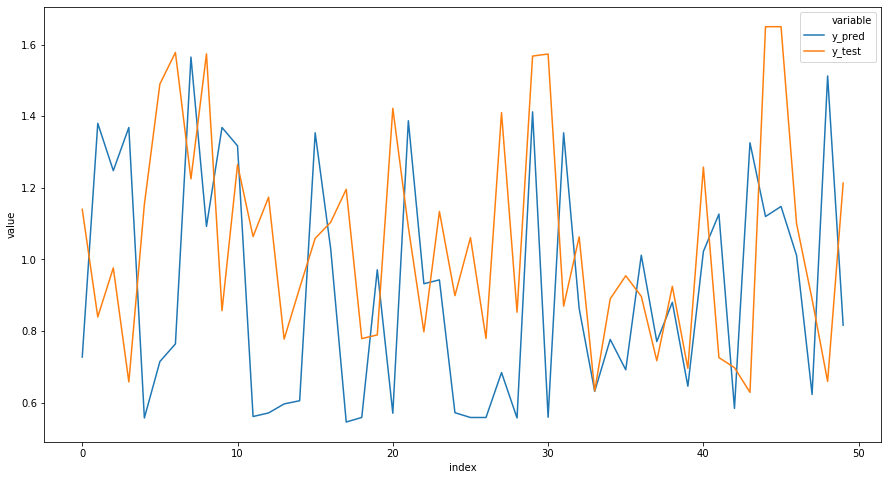

In [24]:
# plot the corresponding y_pred to y_test in quantile range
import seaborn as sns

#y_pred = list(y_pred_test)
y_test_plot = list(y_test_quantile[100:150])
#y_test = list(y_test_ser)
y_pred_plot = list(y_pred_quantile[100:150])
dict_test = {'y_pred': y_pred_plot, 'y_test':y_test_plot}
plt.figure(figsize = (15, 8))
prediction_viz = pd.DataFrame(dict_test)

sns.lineplot(x = 'index', y = 'value', hue = 'variable', 
             data = pd.melt(prediction_viz.reset_index(), ['index']))
